In [1]:
import pandas as pd
import numpy as np

# Load Dataset
df = pd.read_csv(r"S:\HOME\BSc Data Sci\SEM6\MAJOR PROJECT\solar_weather.csv")

# Drop irrelevant columns (adjust as per your actual dataset structure)
df.drop(df.columns[[7, 8, 9, 10, 11, 12, 13, 14, 15, 16]], axis=1, inplace=True)

# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Fill missing values using forward fill
df.fillna(method='ffill', inplace=True)

# Create binary target label: 1 if energy > median, else 0
threshold = df['Energy delta[Wh]'].median()
df['energy_output_label'] = (df['Energy delta[Wh]'] > threshold).astype(int)

# Create engineered feature: Wind Power Index = wind_speed³
df['wind_power_index'] = df['wind_speed'] ** 3

# Drop non-feature columns
df.drop(columns=['Time', 'Energy delta[Wh]'], inplace=True)

# Split features and target
X = df.drop(columns=['energy_output_label'])
y = df['energy_output_label']

C:\Users\sabya\AppData\Local\Temp\ipykernel_1656\3474912961.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9288545583900802

Confusion Matrix:
 [[19786   332]
 [ 2468 16770]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     20118
           1       0.98      0.87      0.92     19238

    accuracy                           0.93     39356
   macro avg       0.93      0.93      0.93     39356
weighted avg       0.93      0.93      0.93     39356



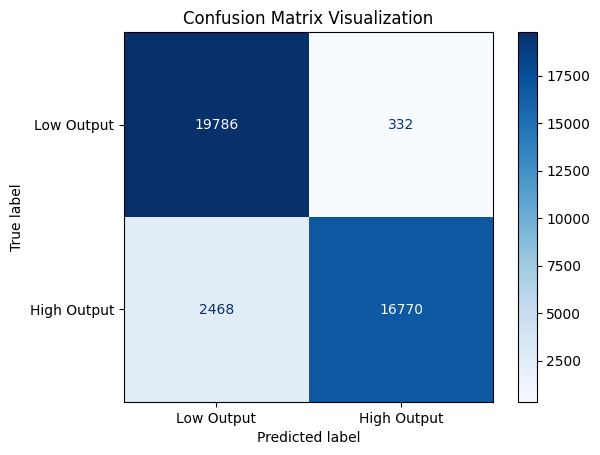

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Display confusion matrix graphically
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Low Output", "High Output"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix Visualization")
plt.show()

In [4]:
from sklearn.feature_selection import RFE

# Recursive Feature Elimination
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Selected features
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", list(selected_features))

Selected Features by RFE: ['GHI', 'temp', 'humidity', 'wind_speed', 'wind_power_index']


In [5]:
from sklearn.model_selection import GridSearchCV
import joblib

# Grid search for best 'C' parameter
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Save the best model
joblib.dump(grid_search.best_estimator_, 'energy_prediction_model.pkl')

Best Parameters: {'C': 100}


['energy_prediction_model.pkl']

In [6]:
# Load saved model
loaded_model = joblib.load('energy_prediction_model.pkl')

# Predict first 10 samples
sample_preds = loaded_model.predict(X_test[:10])

# Create table of predictions
sample_output = pd.DataFrame(X_test[:10], columns=X.columns)
sample_output['Predicted Class'] = sample_preds
sample_output['Predicted Output'] = sample_output['Predicted Class'].map({0: 'Low', 1: 'High'})

# Display selected columns
print(sample_output[['GHI', 'temp', 'humidity', 'wind_speed', 'wind_power_index', 'Predicted Output']])


        GHI      temp  humidity  wind_speed  wind_power_index Predicted Output
0  0.049902 -1.312068  0.909321    0.034174         -0.263890             High
1 -0.624791  0.501473 -0.244198    0.857585          0.400065              Low
2 -0.624791 -1.011896 -1.205464   -0.514767         -0.503854              Low
3 -0.624791 -0.261465  1.101575   -1.008814         -0.618901              Low
4  0.688176 -0.111379 -1.077295    1.132055          0.721908             High
5 -0.624791 -0.749245  0.781153    0.198856         -0.163319              Low
6 -0.624791 -1.086939  0.973406   -0.350085         -0.445893              Low
7 -0.624791  0.551501  0.396646   -0.075615         -0.323090              Low
8 -0.624791 -0.248958  1.101575   -1.832225         -0.677562              Low
9 -0.624791  1.677148 -0.885042    0.967373          0.522109              Low


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Manual metric extraction
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

# Display metrics
metrics_df = pd.DataFrame({
    "Class": ["Low Energy Output (0)", "High Energy Output (1)"],
    "Precision": [precision_0, precision_1],
    "Recall": [recall_0, recall_1],
    "F1 Score": [f1_0, f1_1]
})
print(metrics_df)


                    Class  Precision    Recall  F1 Score
0   Low Energy Output (0)   0.889099  0.983497  0.933919
1  High Energy Output (1)   0.980587  0.871712  0.922950


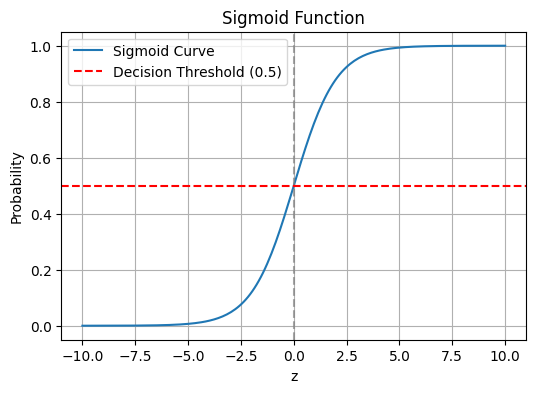

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid Function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 200)
sig = sigmoid(z)

plt.figure(figsize=(6, 4))
plt.plot(z, sig, label='Sigmoid Curve')
plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.axhline(0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.title("Sigmoid Function")
plt.xlabel("z")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()

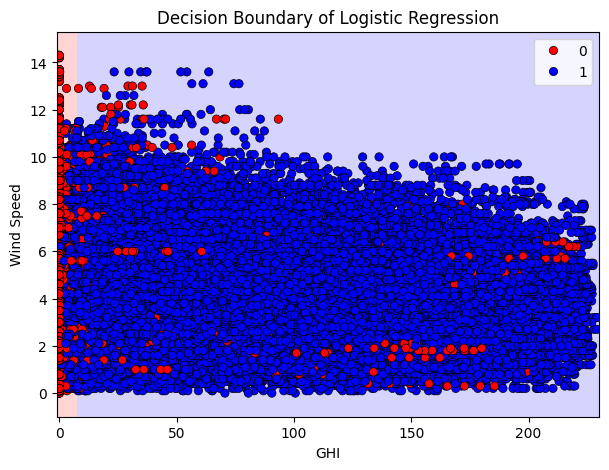

In [9]:
import seaborn as sns
from matplotlib.colors import ListedColormap

# Use only 2 features for visualization
feature_pair = ['GHI', 'wind_speed']
X_vis = df[feature_pair].values
y_vis = df['energy_output_label'].values

# Fit a new model for visualization
from sklearn.linear_model import LogisticRegression
model_vis = LogisticRegression()
model_vis.fit(X_vis, y_vis)

# Create meshgrid
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.5)
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_vis, palette=['red', 'blue'], edgecolor='k')
plt.xlabel('GHI')
plt.ylabel('Wind Speed')
plt.title('Decision Boundary of Logistic Regression')
plt.show()

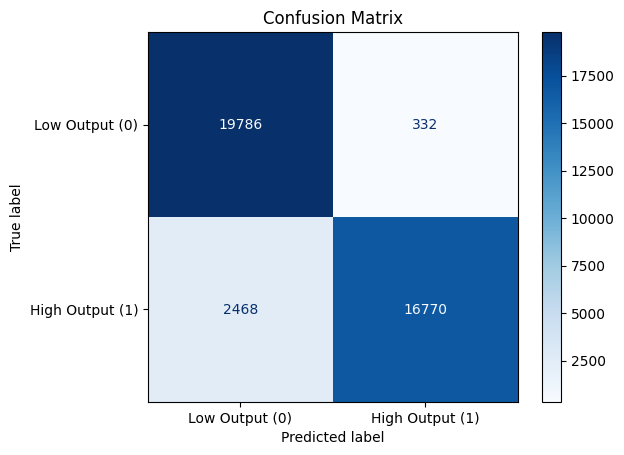

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Low Output (0)", "High Output (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [23]:
from tabulate import tabulate

# Predict first 10 samples from test set
samples = X_test[:10]
predicted_classes = loaded_model.predict(samples)

# Format predictions into a DataFrame
sample_df = pd.DataFrame(samples, columns=X.columns)
sample_df['Predicted Output'] = predicted_classes
sample_df['Predicted Output'] = sample_df['Predicted Output'].map({0: 'Low', 1: 'High'})

# Add Serial Number column
sample_df.insert(0, 'S_No.', range(1, len(sample_df) + 1))

# Round numerical columns to 3 decimal places
rounded_df = sample_df[['S_No.', 'GHI', 'temp', 'humidity', 'wind_speed', 'wind_power_index']].round(3)
rounded_df['Predicted Output'] = sample_df['Predicted Output']

# Display the table
print(tabulate(rounded_df, headers='keys', tablefmt='pretty', showindex=False))



+-------+--------+--------+----------+------------+------------------+------------------+
| S_No. |  GHI   |  temp  | humidity | wind_speed | wind_power_index | Predicted Output |
+-------+--------+--------+----------+------------+------------------+------------------+
|   1   |  0.05  | -1.312 |  0.909   |   0.034    |      -0.264      |       High       |
|   2   | -0.625 | 0.501  |  -0.244  |   0.858    |       0.4        |       Low        |
|   3   | -0.625 | -1.012 |  -1.205  |   -0.515   |      -0.504      |       Low        |
|   4   | -0.625 | -0.261 |  1.102   |   -1.009   |      -0.619      |       Low        |
|   5   | 0.688  | -0.111 |  -1.077  |   1.132    |      0.722       |       High       |
|   6   | -0.625 | -0.749 |  0.781   |   0.199    |      -0.163      |       Low        |
|   7   | -0.625 | -1.087 |  0.973   |   -0.35    |      -0.446      |       Low        |
|   8   | -0.625 | 0.552  |  0.397   |   -0.076   |      -0.323      |       Low        |
|   9   | 